In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution

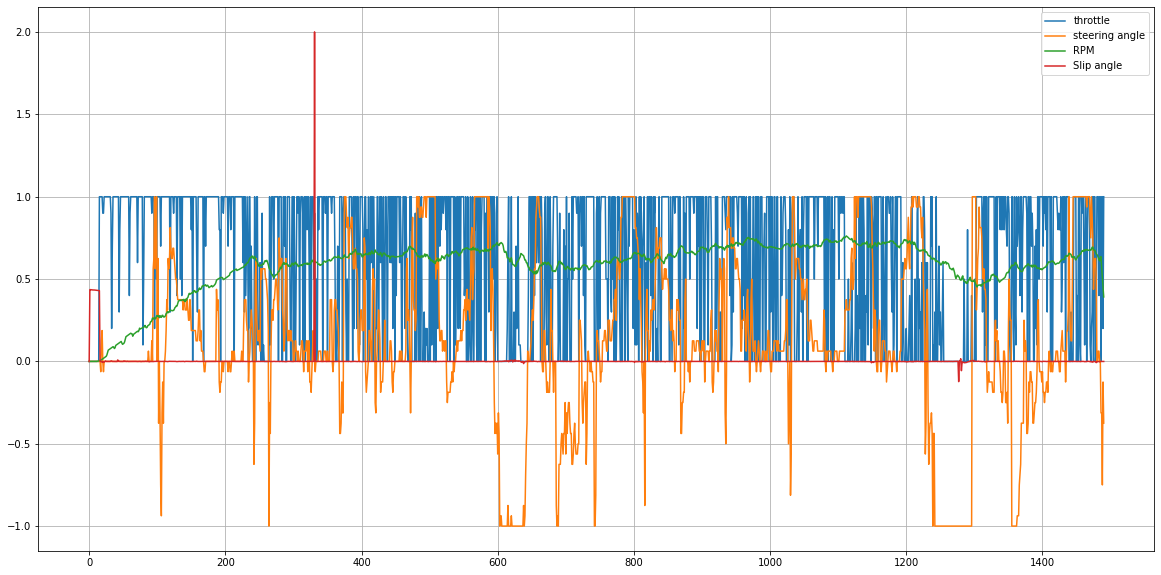

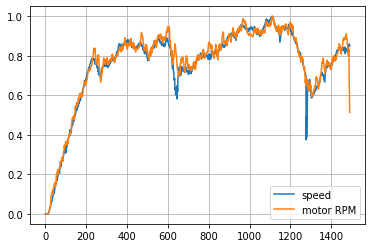

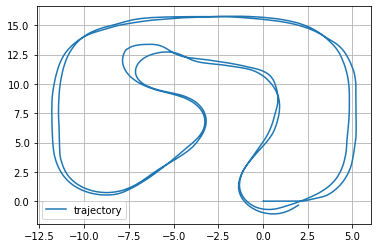

In [2]:
max_rpm = 18000

input_file = "telemetry.csv"
period = 10
data = pd.read_csv(input_file)
data["smooth_motor_rpm"] = np.convolve(data["motor_rpm"], np.ones((period,)) / period, mode='same')

# data = data[:400]

plt.figure(figsize=(20, 10))
plt.grid()
plt.plot(data["throttle_input"], label="throttle")
plt.plot(data["steering_angle_input"], label="steering angle")
plt.plot(data["smooth_motor_rpm"] / max_rpm, label="RPM")
plt.plot((data["slip_angle"] - data["heading_angle"]) / 3.14, label="Slip angle")
plt.legend()
plt.show()
    
top_speed = max(data["speed"])
top_rpm = max(data["smooth_motor_rpm"])
    
plt.grid()
plt.plot(data["speed"] / top_speed, label="speed")
plt.plot(data["smooth_motor_rpm"] / top_rpm, label="motor RPM")
plt.legend()
plt.show()

plt.grid()
plt.plot(data["x"], data["y"], label="trajectory")
plt.legend()
plt.show()

In [128]:
import math
    
def predict_motor_acc(rpm, throttle, steering, x):
    norm_rpm = rpm / max_rpm
    max_torque =  (1 - norm_rpm) * x[0]
    drive_torque = max_torque * throttle
    load_torque = (norm_rpm ** x[2]) * ((x[3] + x[4] * abs(steering)) ** x[5])
    
    if abs(x[1]) < 0.001:
        return 0.0
    
    return (drive_torque - load_torque) / x[1]

def predict_next_motor_state(current, throttle, steering, x, dt):
    motor_rpm_acc = predict_motor_acc(current, throttle, steering, x)
    return max(0, current + max_rpm * motor_rpm_acc * dt)

# def pwm(angle, x):
#     return x[9] * math.degrees(angle) + x[10];

# def time_to_adjust_steering(alpha, beta, x):
#     signal_distance = abs(pwm(alpha, x) - pwm(beta, x))
#     return x[7] * signal_distance + x[8]

def predict_next_steering_state(current_steering_angle, steering, x, dt):
    target_angle = steering * x[6]
    diff = target_angle - current_steering_angle
#     angle_distance = min(diff, 2. * math.pi - diff)
#     time_to_adjust = time_to_adjust_steering(current_steering_angle, target_angle, x)
#     if time_to_adjust == 0:
#         return current_steering_angle    
#     angle_change_rate = angle_distance / time_to_adjust
    angle_change_rate = math.copysign(x[9], diff) if abs(diff) > 0.001 else 0
        
    next_steering_angle = current_steering_angle + angle_change_rate * dt
    next_steering_angle = max(-x[6], min(next_steering_angle, x[6]))
    
    return next_steering_angle

def calculate_speed_with_no_slip_assumption(motor_rpm):
    return (motor_rpm / top_rpm) * top_speed

def slip_angle(steering_angle):
    # 0.5 -> the COG is in the middle of the wheelbase
    return math.atan(math.tan(steering_angle) * 0.5)

def predict_next_state(current, throttle, steering, x, dt):
    motor_rpm = predict_next_motor_state(current["motor_rpm"], throttle, steering, x, dt)
    steering_angle = predict_next_steering_state(current["steering_angle"], steering, x, dt)
    
    v = calculate_speed_with_no_slip_assumption(motor_rpm)

    inv_rpm_perc = 1 - current["motor_rpm"] / top_rpm
    steering_efficiency = min(max(0, x[7] * inv_rpm_perc + x[8]), 1)
    
    
    # just some renaming to make the equations look the same as in the thesis
    theta = current["heading_angle"]
    delta = steering_angle * steering_efficiency
    beta = slip_angle(steering_angle)
    L = 0.32 # wheelbase
    
    dx = v * math.cos(theta + beta)
    dy = v * math.sin(theta + beta)
    dtheta = v * math.cos(beta) * math.tan(delta) / L
    
    heading_angle = current["heading_angle"] + dtheta * dt
    while heading_angle < -math.pi:
        heading_angle += 2 * math.pi
    while heading_angle > math.pi:
        heading_angle -= 2 * math.pi
    
    while steering_angle < -math.pi:
        steering_angle += 2 * math.pi
    while steering_angle > math.pi:
        steering_angle -= 2 * math.pi
    
    return {
        "x": current["x"] + dx * dt,
        "y": current["y"] + dy * dt,
        "heading_angle": heading_angle,
        "motor_rpm": motor_rpm,
        "steering_angle": steering_angle
    }

In [4]:
def predict(y, s, n, dt):
    x0 = [1.46146542e+02, 1.35840204e+03, 9.67287713e-01, 1.01098231e+00,
     1.75427529e-02, 1.77176445e+02]
    
    x = list(x0) + list(y)
    
    state = {
        "x": data.iloc[s]["x"],
        "y": data.iloc[s]["y"],
        "heading_angle": data.iloc[s]["heading_angle"],
        "motor_rpm": 0.,
        "steering_angle": 0.
    }
    
    states = [state]
    for row in data[s:s+n].iterrows():
        state = predict_next_state(state, row[1]["throttle_input"], row[1]["steering_angle_input"], x, dt)
        states.append(state)
    
    return states


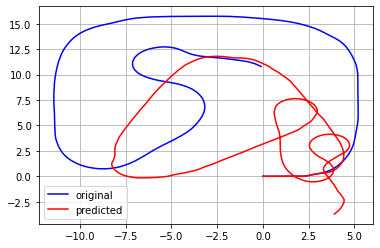

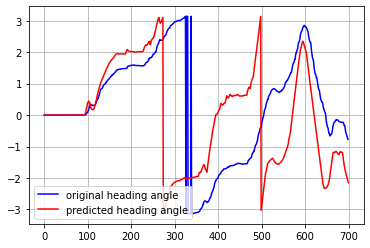

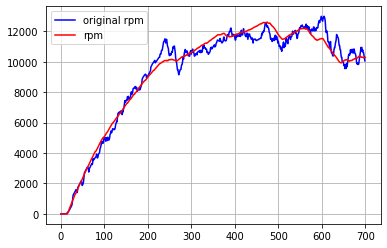

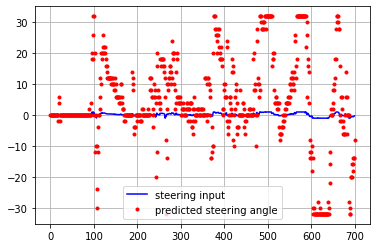

In [118]:
y = [math.radians(32), 0.8, 0.5, 0.2, 0.75]
dt = 1./25.

def fix_angle(angle):
    while angle < -math.pi:
        angle += 2 * math.pi
    while angle > math.pi:
        angle -= 2 * math.pi
    return angle

def test(y, n, dt):
    states = predict(y, 0, n, dt)

    xs = []
    ys = []
    rpms = []
    steering = []
    heading = []

    for state in states:
        xs.append(state["x"])
        ys.append(state["y"])
        rpms.append(state["motor_rpm"])
        steering.append(math.degrees(fix_angle(state["steering_angle"])))
        heading.append(fix_angle(state["heading_angle"]))

    original_heading = []
    for row in data[0:n].iterrows():
        original_heading.append(fix_angle(row[1]["heading_angle"]))
        
    plt.grid()
    plt.plot(data[0:n]["x"], data[0:n]["y"], 'b-', label="original")
    plt.plot(xs, ys, 'r-', label="predicted")
    plt.legend()
    plt.show()

    plt.grid()
    plt.plot(original_heading, 'b-', label="original heading angle")
    plt.plot(heading, 'r-', label="predicted heading angle")
    plt.legend()
    plt.show()

    plt.grid()
    plt.plot(data[0:n]["smooth_motor_rpm"], 'b-', label="original rpm")
    plt.plot(rpms, 'r-', label="rpm")
    plt.legend()
    plt.show()

    plt.grid()
    plt.plot(data[0:n]["steering_angle_input"], 'b-', label="steering input")
    plt.plot(steering, 'r.', label="predicted steering angle")
    plt.legend()
    plt.show()
    
test(y, 700, dt)

In [41]:
dt = 1./25.

def err(y):
    total = 0
    states = predict(y, 300, len(data), dt)
    for state, row in zip(states, data.iterrows()):
        diff = row[1]["heading_angle"] - state["heading_angle"]
        angle_distance = min(diff, 2. * math.pi - diff)
        total += 5 * angle_distance ** 2
        dx = row[1]["x"] - state["x"]
        dy = row[1]["y"] - state["y"]
        total += dx ** 2 + dy ** 2
    return total
  


In [83]:
from scipy.optimize import minimize

# minimize(method=’Nelder-Mead’)
# minimize(method=’Powell’)
# minimize(method=’CG’)
# minimize(method=’BFGS’) - so far the best results
# minimize(method=’Newton-CG’) - nope
# minimize(method=’L-BFGS-B’) - nope
# minimize(method=’TNC’)
# minimize(method=’COBYLA’)
# minimize(method=’SLSQP’)
# minimize(method=’trust-constr’)
# minimize(method=’dogleg’)
# minimize(method=’trust-ncg’)
# minimize(method=’trust-krylov’)
# minimize(method=’trust-exact’)

x0 = [math.radians(24.5), 0.62, 0.38, 0.86]
bounds = [(math.radians(5), math.radians(90)), (0, 2.0), (0, 2.0), (0, 2.0)]
res = minimize(err, x0, method='BFGS', bounds=bounds).x
# res = differential_evolution(err, bnds).x

test(res, 1500, dt)
print(res)
print(math.degrees(res[0]))

/home/simon/.local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


KeyboardInterrupt: 

13711.987595350001


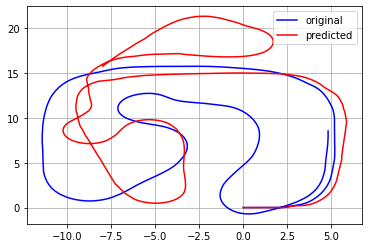

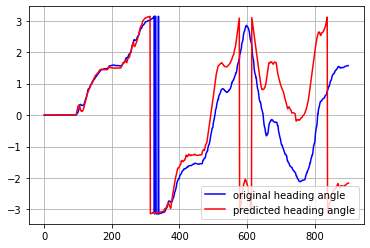

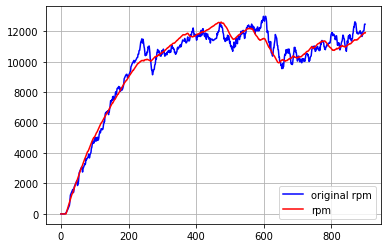

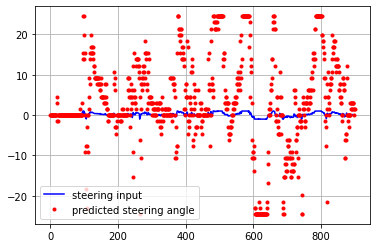

In [139]:
# x = [math.radians(14.5), 0.006, 0.1, 12.7, 1000]
# x = [math.radians(30), 0.75, 0.25, 0.7]
x = [math.radians(24.5), 0.62, 0.38, 0.7]
print(top_rpm)
test(x, 900, dt)